#Cassava Leaf Disease Classification Project#

##Part 1: Import Packages and the Dataset##

####Import Packages###

In [2]:
import pandas as pd
import numpy as np
from sklearn.dummy import DummyClassifier
from google.colab import files
import pandas as pd
import io
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from google.colab import drive
import json
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import random
import tensorflow as tf
import cv2
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from sklearn.model_selection import train_test_split
import re
from functools import partial
import keras
from keras.layers import Dense, Dropout, Input, MaxPooling2D, ZeroPadding2D, Conv2D, Flatten, BatchNormalization
from keras.models import Sequential, Model
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.utils import to_categorical
from tensorflow.keras import regularizers

from tensorflow.keras.layers import MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from zipfile import ZipFile
import time
from datetime import timedelta
from io import BytesIO

# Image manipulation.
import PIL.Image

import pickle
import os

import random
from keras.callbacks import ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np



###Mount the Drive###

In [3]:
import zipfile
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
f = open('/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/label_num_to_disease_map.json')
label_name = json.load(f)
label_name

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

###Load the tfrecords###

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


***Define Some Important Variables***
* Batch_Size: 32
* Labels: 5 different labels in total 
* tf.data.AUTOTUNE: promp the tf.data runtime to tune the value dynamically at runtime. 
* train_path: the path of training dataset directory
* test_path: the path of testing dataset directory
* Image_Size: 512*512

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
Batch_Size = 16 * strategy.num_replicas_in_sync
Batch_Size 

16

In [7]:
labels = list(label_name.keys())
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_path = '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train*.tfrec'
test_path = '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/test_tfrecords/ld_test*.tfrec'
Image_Size_Original = [512, 512]
image_size = 336

In [8]:
print(labels)

['0', '1', '2', '3', '4']


***Preprocess the Image***
* Decode a JPEG-encoded image to a uint8 tensor.
* Divide by 255 to get 0-1 representation 

In [9]:
def preprocess_img(img):
  img_decode = tf.image.decode_jpeg(img, channels = 3)
  img_255 = tf.cast(img_decode, tf.float32)/255.0
  img_res = tf.image.resize(img_255, [image_size,image_size])
  img_resize = tf.reshape(img_res, [image_size, image_size,3])
  return img_resize

***Read the tfrecord***

In [10]:
def read_tfrecord(example, labeled):
  tfrecord_format = {"image":tf.io.FixedLenFeature([], tf.string),
                     "target":tf.io.FixedLenFeature([], tf.int64),
                     } if labeled else {
                     "image": tf.io.FixedLenFeature([], tf.string),
                     "image_name": tf.io.FixedLenFeature([], tf.string)
                     }
  example = tf.io.parse_single_example(example, tfrecord_format)
  
  img_res = preprocess_img(example['image'])
  
  if labeled:
    label = tf.cast(example['target'], tf.int32)
    return img_res, label
  else: 
    id = example['image_name']
    return img_res, id

***Load the dataset***

In [11]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    return dataset

###Splitting Strategy###

In [12]:
train_list = tf.io.gfile.glob(train_path)
test_list = tf.io.gfile.glob(test_path)
train_list, test_list

(['/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train00-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train01-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train02-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train03-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train04-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train05-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train06-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train07-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train08-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfre

In [13]:
df_training, df_validation = train_test_split(train_list,
                                              test_size=0.2, random_state=42)
df_testing = tf.io.gfile.glob(test_list)

In [14]:
len(df_training), len(df_validation), len(df_testing)

(12, 4, 1)

In [15]:
df_training, df_validation, df_testing

(['/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train13-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train11-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train08-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train09-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train02-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train15-1327.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train04-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train07-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfrecords/ld_train10-1338.tfrec',
  '/content/gdrive/Shareddrives/2040 (unofficial)/my_data/data/train_tfre

###Image Augmentation###

In [16]:
def train_augmentation(image, label):
    # image_augmentation 
    # image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    # image = tf.image.random_hue(image, 0.2)
    # image = tf.image.random_crop(image,[image_size, image_size, 3])
    # image = tf.image.random_brightness(image, max_delta = 0.5)
    # image = tf.image.random_saturation(image, lower = 5, upper = 10)
    # image = tf.image.random_contrast(image, 0.2, 0.5)
    # image = tf.image.random_jpeg_quality(image, 75, 95)
    return image, label

###Load the dataset###

* repeat: repeats this dataset so each original value is seen infinitely. 
* shuffle: randomly shuffles the elements of this dataet. 
* prefetch: allows later elements to be prepared while the current element is being processed.

In [17]:
def get_training_dataset():
    df_train = load_dataset(df_training, labeled=True)  
    df_train = df_train.map(train_augmentation, num_parallel_calls=AUTOTUNE)  
    df_train = df_train.repeat()
    df_train = df_train.shuffle(2048)
    df_train = df_train.batch(Batch_Size)
    df_train = df_train.prefetch(AUTOTUNE) 
    return df_train

In [18]:
def get_validation_dataset(ordered=False):
    df_valid = load_dataset(df_validation, labeled=True, ordered=ordered) 
    df_valid = df_valid.batch(Batch_Size)
    df_valid = df_valid.cache()
    df_valid = df_valid.prefetch(AUTOTUNE)
    return df_valid

In [19]:
def get_test_dataset(ordered=False):
    df_test = load_dataset(df_testing, labeled=False, ordered=ordered)
    df_test = df_test.batch(Batch_Size)
    df_test = df_test.prefetch(AUTOTUNE)
    return df_test

In [20]:
def counting(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [21]:
num_training = counting(df_training)
num_valid = counting(df_validation)
num_test = counting(df_testing)

print('This Dataset: {} training images, {} validation images, {} (unlabeled) test images'.format(
    num_training, num_valid, num_test))

This Dataset: 16045 training images, 5352 validation images, 1 (unlabeled) test images


In [22]:
df_train = get_training_dataset()
df_valid = get_validation_dataset()
df_test = get_test_dataset()

In [23]:
df_train, df_valid, df_test

(<PrefetchDataset shapes: ((None, 336, 336, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 336, 336, 3), (None,)), types: (tf.float32, tf.int32)>,
 <PrefetchDataset shapes: ((None, 336, 336, 3), (None,)), types: (tf.float32, tf.string)>)

In [24]:
print("Training dataset:")
for image, label in df_train.take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Training dataset labels:", label.numpy())
print("Validation dataset:")
for image, label in df_valid.take(3):
    print(image.numpy().shape, label.numpy().shape)
    print("Validation dataset labels:", label.numpy())
print("Test dataset:")
for image, idnum in df_test.take(3):
    print(image.numpy().shape, idnum.numpy().shape)
    print("Test data IDs:", idnum.numpy().astype('U')) 

Training dataset:
(16, 336, 336, 3) (16,)
Training dataset labels: [3 3 3 3 3 3 3 3 3 3 3 2 1 3 4 2]
(16, 336, 336, 3) (16,)
Training dataset labels: [0 3 3 2 3 3 3 4 3 3 3 1 2 3 2 3]
(16, 336, 336, 3) (16,)
Training dataset labels: [3 3 3 3 1 3 1 3 3 3 3 3 4 3 3 3]
Validation dataset:
(16, 336, 336, 3) (16,)
Validation dataset labels: [0 3 3 3 1 1 1 1 3 3 3 3 2 3 0 2]
(16, 336, 336, 3) (16,)
Validation dataset labels: [4 4 3 4 3 2 3 0 1 2 3 3 3 3 2 3]
(16, 336, 336, 3) (16,)
Validation dataset labels: [3 1 4 4 0 3 3 3 3 3 3 3 1 3 3 2]
Test dataset:
(1, 336, 336, 3) (1,)
Test data IDs: ['2216849948.jpg']


##Part 2: Model##

**Data Augmentation**

In [25]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip(mode='horizontal_and_vertical'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(factor=(-0.2,0.2)),
  tf.keras.layers.experimental.preprocessing.RandomCrop(height = image_size, width = image_size) # 80%
  # tf.keras.layers.experimental.preprocessing.RandomHeight(factor=0.2),
  # tf.keras.layers.experimental.preprocessing.RandomWidth(factor=0.2),
  # tf.keras.layers.experimental.preprocessing.RandomContrast(0.25), try
  # tf.keras.layers.experimental.preprocessing.RandomZoom(0.5, 0.2)
])

## ResNet：YunXuan

#### Test1: 0.8714 0.8684

In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
def make_RS():
  inputshape = (image_size, image_size, 3)
  inputs = tf.keras.Input(shape=inputshape)
  x = data_augmentation(inputs)

  base_model = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape = inputshape,
                        weights="imagenet")
  
  x = base_model(x)
  model = tf.keras.layers.GlobalMaxPooling2D()(x)

  model = BatchNormalization()(model)
  model = Dense(512, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.001, l2 = 0.001))(model)

  model = BatchNormalization()(model)
  model = Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)
  
  model = BatchNormalization()(model)
  model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)
  
  out = Dense(5, activation = "softmax")(model)

  model = Model(inputs = inputs, outputs = out)
  return model

model_RS1 = make_RS()

94773248/94765736 [==============================] - 1s 0us/step


#### Test3: 336 0.8718 0.8661

In [ ]:
# image_size= 336
def make_RS():
  inputshape = (image_size, image_size, 3)
  inputs = tf.keras.Input(shape=inputshape)
  x = data_augmentation(inputs)

  base_model = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape = inputshape,
                        weights="imagenet")
  
  x = base_model(x)
  model = tf.keras.layers.GlobalMaxPooling2D()(x) 

  model = BatchNormalization()(model) 
  model = Dense(512, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.001, l2 = 0.001))(model)
  
  model = Dropout(0.3)(model)
  model = BatchNormalization()(model)
  model = Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)
 
  model = BatchNormalization()(model)
  model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)

  model = Dropout(0.4)(model)
  out = Dense(5, activation = "softmax")(model)

  model = Model(inputs = inputs, outputs = out)

  return model

model_RS1 = make_RS()

In [ ]:
opt = keras.optimizers.Adam(1e-4)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr = 1e-5, cooldown=2)

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights = True)
model_RS1.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print(Batch_Size, image_size) 

16 336


In [ ]:
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_RS1 = model_RS1.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=50, callbacks = [es, rlrop])

Epoch 1/50
1002/1002 [==============================] - 176s 164ms/step - loss: 92.6222 - accuracy: 0.3805 - val_loss: 47.9003 - val_accuracy: 0.7210
Epoch 2/50
1002/1002 [==============================] - 161s 160ms/step - loss: 38.4011 - accuracy: 0.6963 - val_loss: 17.7532 - val_accuracy: 0.8127
Epoch 3/50
1002/1002 [==============================] - 163s 162ms/step - loss: 14.3001 - accuracy: 0.7708 - val_loss: 6.2263 - val_accuracy: 0.8205
Epoch 4/50
1002/1002 [==============================] - 160s 160ms/step - loss: 4.8756 - accuracy: 0.7884 - val_loss: 2.0962 - val_accuracy: 0.7983
Epoch 5/50
1002/1002 [==============================] - 171s 171ms/step - loss: 1.8160 - accuracy: 0.7859 - val_loss: 1.2369 - val_accuracy: 0.8204
Epoch 6/50
1002/1002 [==============================] - 155s 154ms/step - loss: 1.3256 - accuracy: 0.7888 - val_loss: 1.1641 - val_accuracy: 0.7826
Epoch 7/50
1002/1002 [==============================] - 152s 151ms/step - loss: 1.2032 - accuracy: 0.7872 -

In [ ]:
# save model
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)


save_model(model_RS1, 'ResNet_model_Yunxuan_8724')

Saved trained model at /content/saved_models/ResNet_model_Yunxuan_8724.h5 


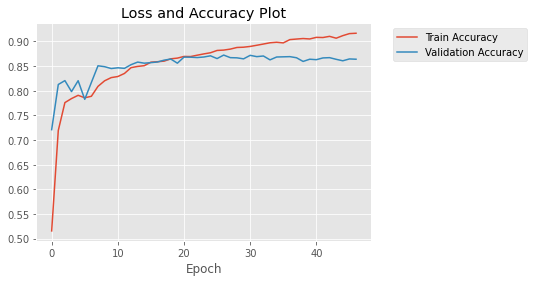

In [ ]:
N = 47
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RS1.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_RS1.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

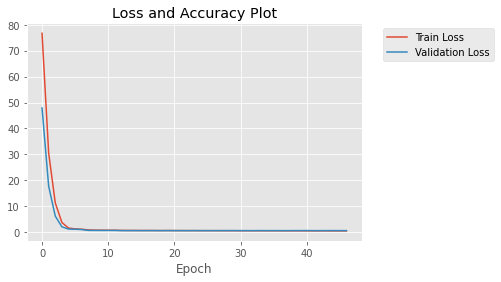

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_RS1.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_RS1.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## VGG16

#### VGG Baseline

In [ ]:
from keras.applications.vgg16 import VGG16

def build_base():
  base_model = VGG16(weights = 'imagenet', include_top = False, input_shape=(224,224,3))
  base_model.trainable = False
  model = base_model.output
  model = Flatten()(model)
  out = Dense(5, activation="softmax")(model)
  model = Model(inputs = base_model.input, outputs = out)
  return model

In [ ]:
Batch_Size = 128
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size

In [ ]:
model_base = build_base()
model_base.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model_base.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=30)

Epoch 1/30
125/125 [==============================] - 11s 47ms/step - loss: 2.7640 - accuracy: 0.5220 - val_loss: 3.2188 - val_accuracy: 0.6341
Epoch 2/30
125/125 [==============================] - 5s 43ms/step - loss: 1.7803 - accuracy: 0.6071 - val_loss: 1.1786 - val_accuracy: 0.6555
Epoch 3/30
125/125 [==============================] - 5s 44ms/step - loss: 1.7124 - accuracy: 0.6118 - val_loss: 2.0627 - val_accuracy: 0.6585
Epoch 4/30
125/125 [==============================] - 6s 45ms/step - loss: 1.7221 - accuracy: 0.6200 - val_loss: 3.0619 - val_accuracy: 0.3049
Epoch 5/30
125/125 [==============================] - 5s 43ms/step - loss: 1.7754 - accuracy: 0.5966 - val_loss: 2.4203 - val_accuracy: 0.4832
Epoch 6/30
125/125 [==============================] - 5s 44ms/step - loss: 1.7172 - accuracy: 0.6160 - val_loss: 1.5324 - val_accuracy: 0.6753
Epoch 7/30
125/125 [==============================] - 5s 43ms/step - loss: 1.8625 - accuracy: 0.6133 - val_loss: 2.8365 - val_accuracy: 0.368

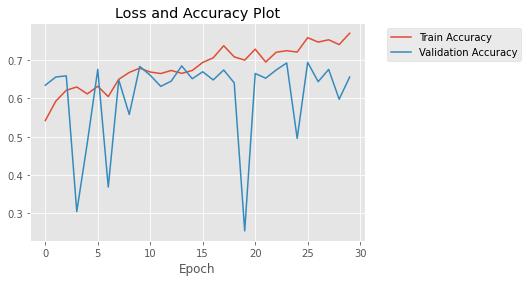

In [ ]:
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

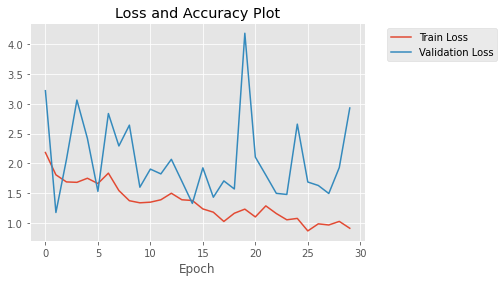

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#### Test1: VGG16 0.86+

In [26]:
from keras.applications.vgg16 import VGG16

def create_vgg():
  inputshape = (image_size, image_size, 3)
  inputs = tf.keras.Input(shape=inputshape)
  x = data_augmentation(inputs)

  base_model = VGG16(include_top = False, input_shape = inputshape, weights="imagenet")

  x = base_model(x)

  model = Flatten()(x)
  model = Dense(256, activation='relu')(model)
  model = Dropout(0.5)(model)

  model = Dense(128, activation='relu')(model)
  model = Dropout(0.5)(model)

  out = Dense(5, activation='softmax')(model)
  
  model = Model(inputs = inputs, outputs = out)
  return model

model_vgg = create_vgg()

In [27]:
opt = keras.optimizers.Nadam(learning_rate = 1e-5)
model_vgg.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [28]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights = True)

In [29]:
Batch_Size = 16
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=50, callbacks = [es])

Epoch 1/50
1002/1002 [==============================] - 311s 286ms/step - loss: 1.1247 - accuracy: 0.6040 - val_loss: 0.7655 - val_accuracy: 0.6989
Epoch 2/50
1002/1002 [==============================] - 282s 281ms/step - loss: 0.8140 - accuracy: 0.6939 - val_loss: 0.6830 - val_accuracy: 0.7734
Epoch 3/50
1002/1002 [==============================] - 282s 281ms/step - loss: 0.6707 - accuracy: 0.7591 - val_loss: 0.5263 - val_accuracy: 0.8095
Epoch 4/50
1002/1002 [==============================] - 282s 281ms/step - loss: 0.6101 - accuracy: 0.7925 - val_loss: 0.4875 - val_accuracy: 0.8338
Epoch 5/50
1002/1002 [==============================] - 282s 281ms/step - loss: 0.5566 - accuracy: 0.8165 - val_loss: 0.5227 - val_accuracy: 0.8166
Epoch 6/50
1002/1002 [==============================] - 282s 282ms/step - loss: 0.5484 - accuracy: 0.8227 - val_loss: 0.4589 - val_accuracy: 0.8447
Epoch 7/50
1002/1002 [==============================] - 283s 282ms/step - loss: 0.5204 - accuracy: 0.8287 - val_

In [30]:
# save model
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)


save_model(model_vgg, 'VGG_model')

Saved trained model at /content/saved_models/VGG_model.h5 


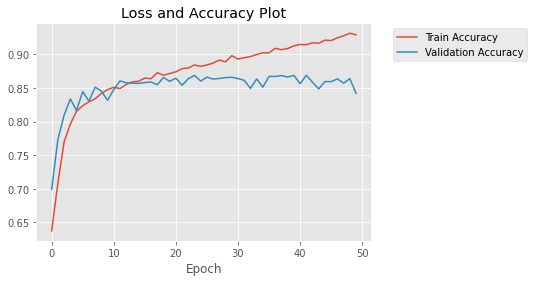

In [31]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

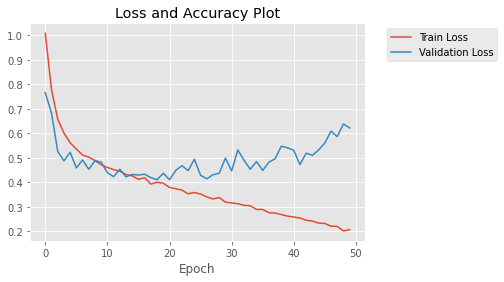

In [32]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

#### Test 2: VGG16 0.87+

In [ ]:
from keras.applications.vgg16 import VGG16

def create_vgg():
    inputshape = (image_size, image_size, 3)
    inputs = tf.keras.Input(shape=inputshape)
    x = data_augmentation(inputs)

    base_model = VGG16(include_top = False, input_shape = inputshape, weights="imagenet")

    x = base_model(x)

    model = tf.keras.layers.GlobalAveragePooling2D()(x) 

    model = Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)
    model = Dropout(0.5)(model)

    model = Dense(128,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)
    model = Dropout(0.5)(model)
    out = Dense(5, activation = "softmax")(model)
  
    model = Model(inputs = inputs, outputs = out)
    return model

model_vgg = create_vgg()

In [ ]:
opt = keras.optimizers.Nadam(learning_rate = 1e-5)
model_vgg.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20, restore_best_weights = True)
print(image_size)

300


In [ ]:
Batch_Size = 16
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history_IR = model_vgg.fit(df_train,steps_per_epoch=steps_per_epoch, 
                    validation_data=df_valid, validation_steps=valid_steps, epochs=50, callbacks = [es])

Epoch 1/50
1002/1002 [==============================] - 165s 157ms/step - loss: 96.2736 - accuracy: 0.5614 - val_loss: 84.0473 - val_accuracy: 0.6869
Epoch 2/50
1002/1002 [==============================] - 146s 145ms/step - loss: 80.4275 - accuracy: 0.6716 - val_loss: 69.7747 - val_accuracy: 0.7216
Epoch 3/50
1002/1002 [==============================] - 145s 145ms/step - loss: 66.6005 - accuracy: 0.7274 - val_loss: 57.4251 - val_accuracy: 0.7992
Epoch 4/50
1002/1002 [==============================] - 145s 145ms/step - loss: 54.7898 - accuracy: 0.7650 - val_loss: 46.9811 - val_accuracy: 0.8142
Epoch 5/50
1002/1002 [==============================] - 145s 145ms/step - loss: 44.7630 - accuracy: 0.7814 - val_loss: 38.1400 - val_accuracy: 0.8176
Epoch 6/50
1002/1002 [==============================] - 145s 145ms/step - loss: 36.2722 - accuracy: 0.7976 - val_loss: 30.7014 - val_accuracy: 0.8271
Epoch 7/50
1002/1002 [==============================] - 145s 145ms/step - loss: 29.1778 - accuracy: 

In [ ]:
# save model
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)


save_model(model_vgg, 'VGG_model')

Saved trained model at /content/saved_models/VGG_model.h5 


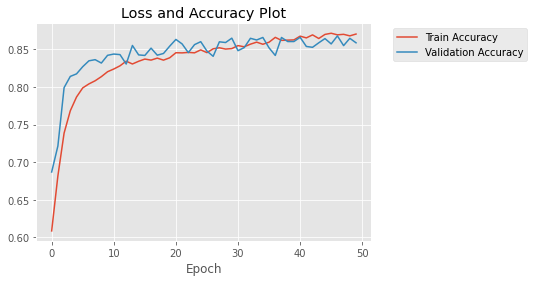

In [ ]:
N = 50
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history_IR.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

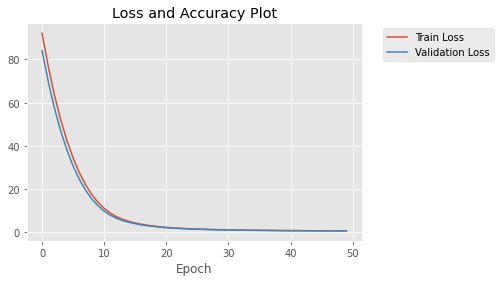

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history_IR.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history_IR.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

## Hyperparameter Tuning: ResNet

#### l1, l2

In [ ]:
# tuning learning rate
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

def plot_training_resnet_lr(df_train, df_valid, lr1, lr2, ax=None):
    inputshape = (image_size, image_size, 3)
    inputs = tf.keras.Input(shape=inputshape)
    x = data_augmentation(inputs)

    base_model = tf.keras.applications.ResNet50(include_top = False, 
                        input_shape = inputshape,
                        weights="imagenet")
  
    x = base_model(x)
    model = tf.keras.layers.GlobalMaxPooling2D()(x) 

    model = BatchNormalization()(model) 
    model = Dense(512, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = lr1, l2 = lr1))(model)
    
    model = Dropout(0.3)(model)
    model = BatchNormalization()(model)
    model = Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = lr2, l2 = lr2))(model)
    
    model = BatchNormalization()(model)
    model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1L2(l1 = lr2, l2 = lr2))(model)

    model = Dropout(0.4)(model)
    out = Dense(5, activation = "softmax")(model)

    model = Model(inputs = inputs, outputs = out)

    opt = keras.optimizers.Adam(1e-4)
    rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr = 1e-5, cooldown=2)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    Batch_Size = 16
    steps_per_epoch = num_training // Batch_Size
    valid_steps = num_valid // Batch_Size
    history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                        validation_data=df_valid, validation_steps=valid_steps, epochs=5, callbacks = [rlrop])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    ax.title.set_text('l1={}, l2={}'.format(lr1, lr2))
    return [max(train_acc), max(val_acc), lr1, lr2]
      
lr1 = [0.001, 0.01]
lr2 = [0.001, 0.01]

Epoch 1/5
1002/1002 [==============================] - 209s 199ms/step - loss: 36.3354 - accuracy: 0.3407 - val_loss: 30.1601 - val_accuracy: 0.5421
Epoch 2/5
1002/1002 [==============================] - 200s 199ms/step - loss: 27.3877 - accuracy: 0.6461 - val_loss: 20.3033 - val_accuracy: 0.7573
Epoch 3/5
1002/1002 [==============================] - 199s 199ms/step - loss: 18.3202 - accuracy: 0.7168 - val_loss: 12.4358 - val_accuracy: 0.7994
Epoch 4/5
1002/1002 [==============================] - 199s 199ms/step - loss: 11.1864 - accuracy: 0.7377 - val_loss: 7.7683 - val_accuracy: 0.7173
Epoch 5/5
1002/1002 [==============================] - 199s 199ms/step - loss: 6.9241 - accuracy: 0.7598 - val_loss: 5.0265 - val_accuracy: 0.8194
Epoch 1/5
1002/1002 [==============================] - 209s 200ms/step - loss: 35.4619 - accuracy: 0.4639 - val_loss: 28.3352 - val_accuracy: 0.7002
Epoch 2/5
1002/1002 [==============================] - 198s 198ms/step - loss: 26.0485 - accuracy: 0.6695 - v

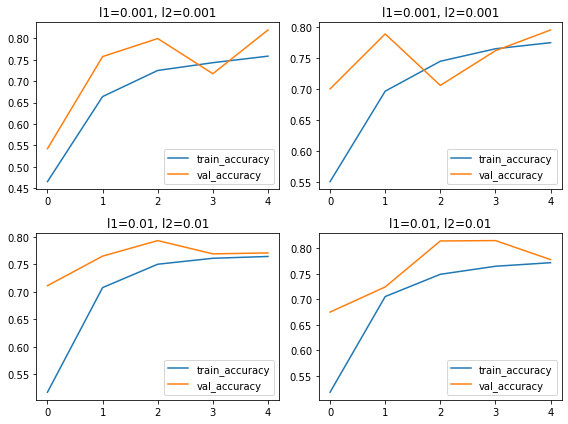

In [ ]:
fig, axes = plt.subplots(2, 2, figsize = (8, 6))

res_lr1_lr2 = []
for i in range(2):
  for j in range(2):
    keras.backend.clear_session()
    res_lr1_lr2.append(plot_training_resnet_lr(df_train, df_valid, lr1[i], lr2[i], axes[i][j]))
fig.tight_layout() 

In [ ]:
max(res_lr1_lr2)

[0.7745134830474854, 0.794910192489624, 0.001, 0.001]

#### units



In [ ]:
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

def plot_training_resnet_n(df_train, df_valid, n1, n2, n3, ax=None):
    inputshape = (image_size, image_size, 3)
    inputs = tf.keras.Input(shape=inputshape)
    x = data_augmentation(inputs)

    base_model = tf.keras.applications.ResNet50(include_top = False, 
                          input_shape = inputshape,
                          weights="imagenet")
    
    x = base_model(x)
    model = tf.keras.layers.GlobalMaxPooling2D()(x) 

    model = BatchNormalization()(model) 
    model = Dense(n1, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.001, l2 = 0.001))(model)
    
    model = Dropout(0.3)(model)
    model = BatchNormalization()(model)
    model = Dense(n2, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)
    model = BatchNormalization()(model)
    model = Dense(n3,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)

    model = Dropout(0.4)(model)
    out = Dense(5, activation = "softmax")(model)

    model = Model(inputs = inputs, outputs = out)


    opt = keras.optimizers.Adam(1e-4)
    rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr = 1e-5, cooldown=2)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    Batch_Size = 16
    steps_per_epoch = num_training // Batch_Size
    valid_steps = num_valid // Batch_Size
    history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                        validation_data=df_valid, validation_steps=valid_steps, epochs=5, callbacks = [rlrop])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    ax.title.set_text('n1={}, n2={}, n3={}'.format(n1, n2, n3))
    return [max(train_acc), max(val_acc), n1, n2, n3]
      
n1 = [1024, 512]
n2 = [256, 128]
n3 = [32, 16]

Epoch 1/5
1002/1002 [==============================] - 210s 200ms/step - loss: 130.5368 - accuracy: 0.4637 - val_loss: 53.5220 - val_accuracy: 0.6566
Epoch 2/5
1002/1002 [==============================] - 199s 199ms/step - loss: 41.0539 - accuracy: 0.7172 - val_loss: 16.3227 - val_accuracy: 0.7799
Epoch 3/5
1002/1002 [==============================] - 199s 199ms/step - loss: 12.2014 - accuracy: 0.7733 - val_loss: 3.8807 - val_accuracy: 0.8043
Epoch 4/5
1002/1002 [==============================] - 199s 199ms/step - loss: 2.9722 - accuracy: 0.7710 - val_loss: 1.6634 - val_accuracy: 0.7779
Epoch 5/5
1002/1002 [==============================] - 199s 199ms/step - loss: 1.5777 - accuracy: 0.7712 - val_loss: 1.4262 - val_accuracy: 0.7472
Epoch 1/5
1002/1002 [==============================] - 210s 200ms/step - loss: 92.2429 - accuracy: 0.4439 - val_loss: 48.8629 - val_accuracy: 0.6660
Epoch 2/5
1002/1002 [==============================] - 199s 199ms/step - loss: 39.4890 - accuracy: 0.6892 - va

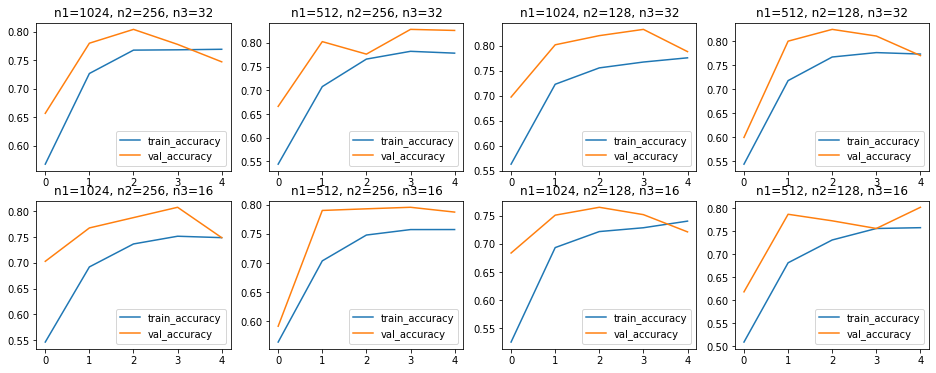

In [ ]:
fig, axes = plt.subplots(2, 4, figsize = (16, 6))
res_n1_n2_n3 = []

keras.backend.clear_session()
res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[0], n2[0], n3[0], axes[0][0]))

res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[1], n2[0], n3[0], axes[0][1]))

res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[0], n2[1], n3[0], axes[0][2]))

res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[1], n2[1], n3[0], axes[0][3]))

res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[0], n2[0], n3[1], axes[1][0]))

res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[1], n2[0], n3[1], axes[1][1]))

res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[0], n2[1], n3[1], axes[1][2]))

res_n1_n2_n3.append(plot_training_resnet_n(df_train, df_valid, n1[1], n2[1], n3[1], axes[1][3]))

#### dropout rate

In [ ]:
from keras.applications.vgg16 import VGG16
import matplotlib.pyplot as plt

def plot_training_resnet_n(df_train, df_valid, dp1, dp2, ax=None):
    inputshape = (image_size, image_size, 3)
    inputs = tf.keras.Input(shape=inputshape)
    x = data_augmentation(inputs)

    base_model = tf.keras.applications.ResNet50(include_top = False, 
                          input_shape = inputshape,
                          weights="imagenet")
    
    x = base_model(x)
    model = tf.keras.layers.GlobalMaxPooling2D()(x) 

    model = BatchNormalization()(model) 
    model = Dense(512, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.001, l2 = 0.001))(model)
    
    model = Dropout(dp1)(model)
    model = BatchNormalization()(model)
    model = Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)
    model = BatchNormalization()(model)
    model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)

    model = Dropout(dp2)(model)
    out = Dense(5, activation = "softmax")(model)

    model = Model(inputs = inputs, outputs = out)


    opt = keras.optimizers.Adam(1e-4)
    rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr = 1e-5, cooldown=2)

    model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    Batch_Size = 16
    steps_per_epoch = num_training // Batch_Size
    valid_steps = num_valid // Batch_Size
    history = model.fit(df_train,steps_per_epoch=steps_per_epoch, 
                        validation_data=df_valid, validation_steps=valid_steps, epochs=5, callbacks = [rlrop])

    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    ax.plot(train_acc, label='train_accuracy')
    ax.plot(val_acc, label='val_accuracy')
    ax.legend()
    ax.title.set_text('dp1={}, dp2={}'.format(dp1, dp2))
    return [max(train_acc), max(val_acc), dp1, dp2]
      
dp1 = [0.2,0.3,0.4,0.5]
dp2 = [0.2,0.3,0.4,0.5]

Epoch 1/5
1002/1002 [==============================] - 210s 200ms/step - loss: 3539.4628 - accuracy: 0.2944 - val_loss: 103.0063 - val_accuracy: 0.5457
Epoch 2/5
1002/1002 [==============================] - 199s 198ms/step - loss: 46.4766 - accuracy: 0.6351 - val_loss: 3.9098 - val_accuracy: 0.6123
Epoch 3/5
1002/1002 [==============================] - 199s 198ms/step - loss: 3.7179 - accuracy: 0.6187 - val_loss: 3.7049 - val_accuracy: 0.6121
Epoch 4/5
1002/1002 [==============================] - 199s 199ms/step - loss: 3.7210 - accuracy: 0.6188 - val_loss: 3.7289 - val_accuracy: 0.6121
Epoch 5/5
1002/1002 [==============================] - 201s 201ms/step - loss: 3.7473 - accuracy: 0.6139 - val_loss: 3.7347 - val_accuracy: 0.6121
Epoch 1/5
1002/1002 [==============================] - 210s 200ms/step - loss: 3534.9570 - accuracy: 0.4036 - val_loss: 102.1822 - val_accuracy: 0.6525
Epoch 2/5
1002/1002 [==============================] - 199s 199ms/step - loss: 46.3588 - accuracy: 0.6592 -

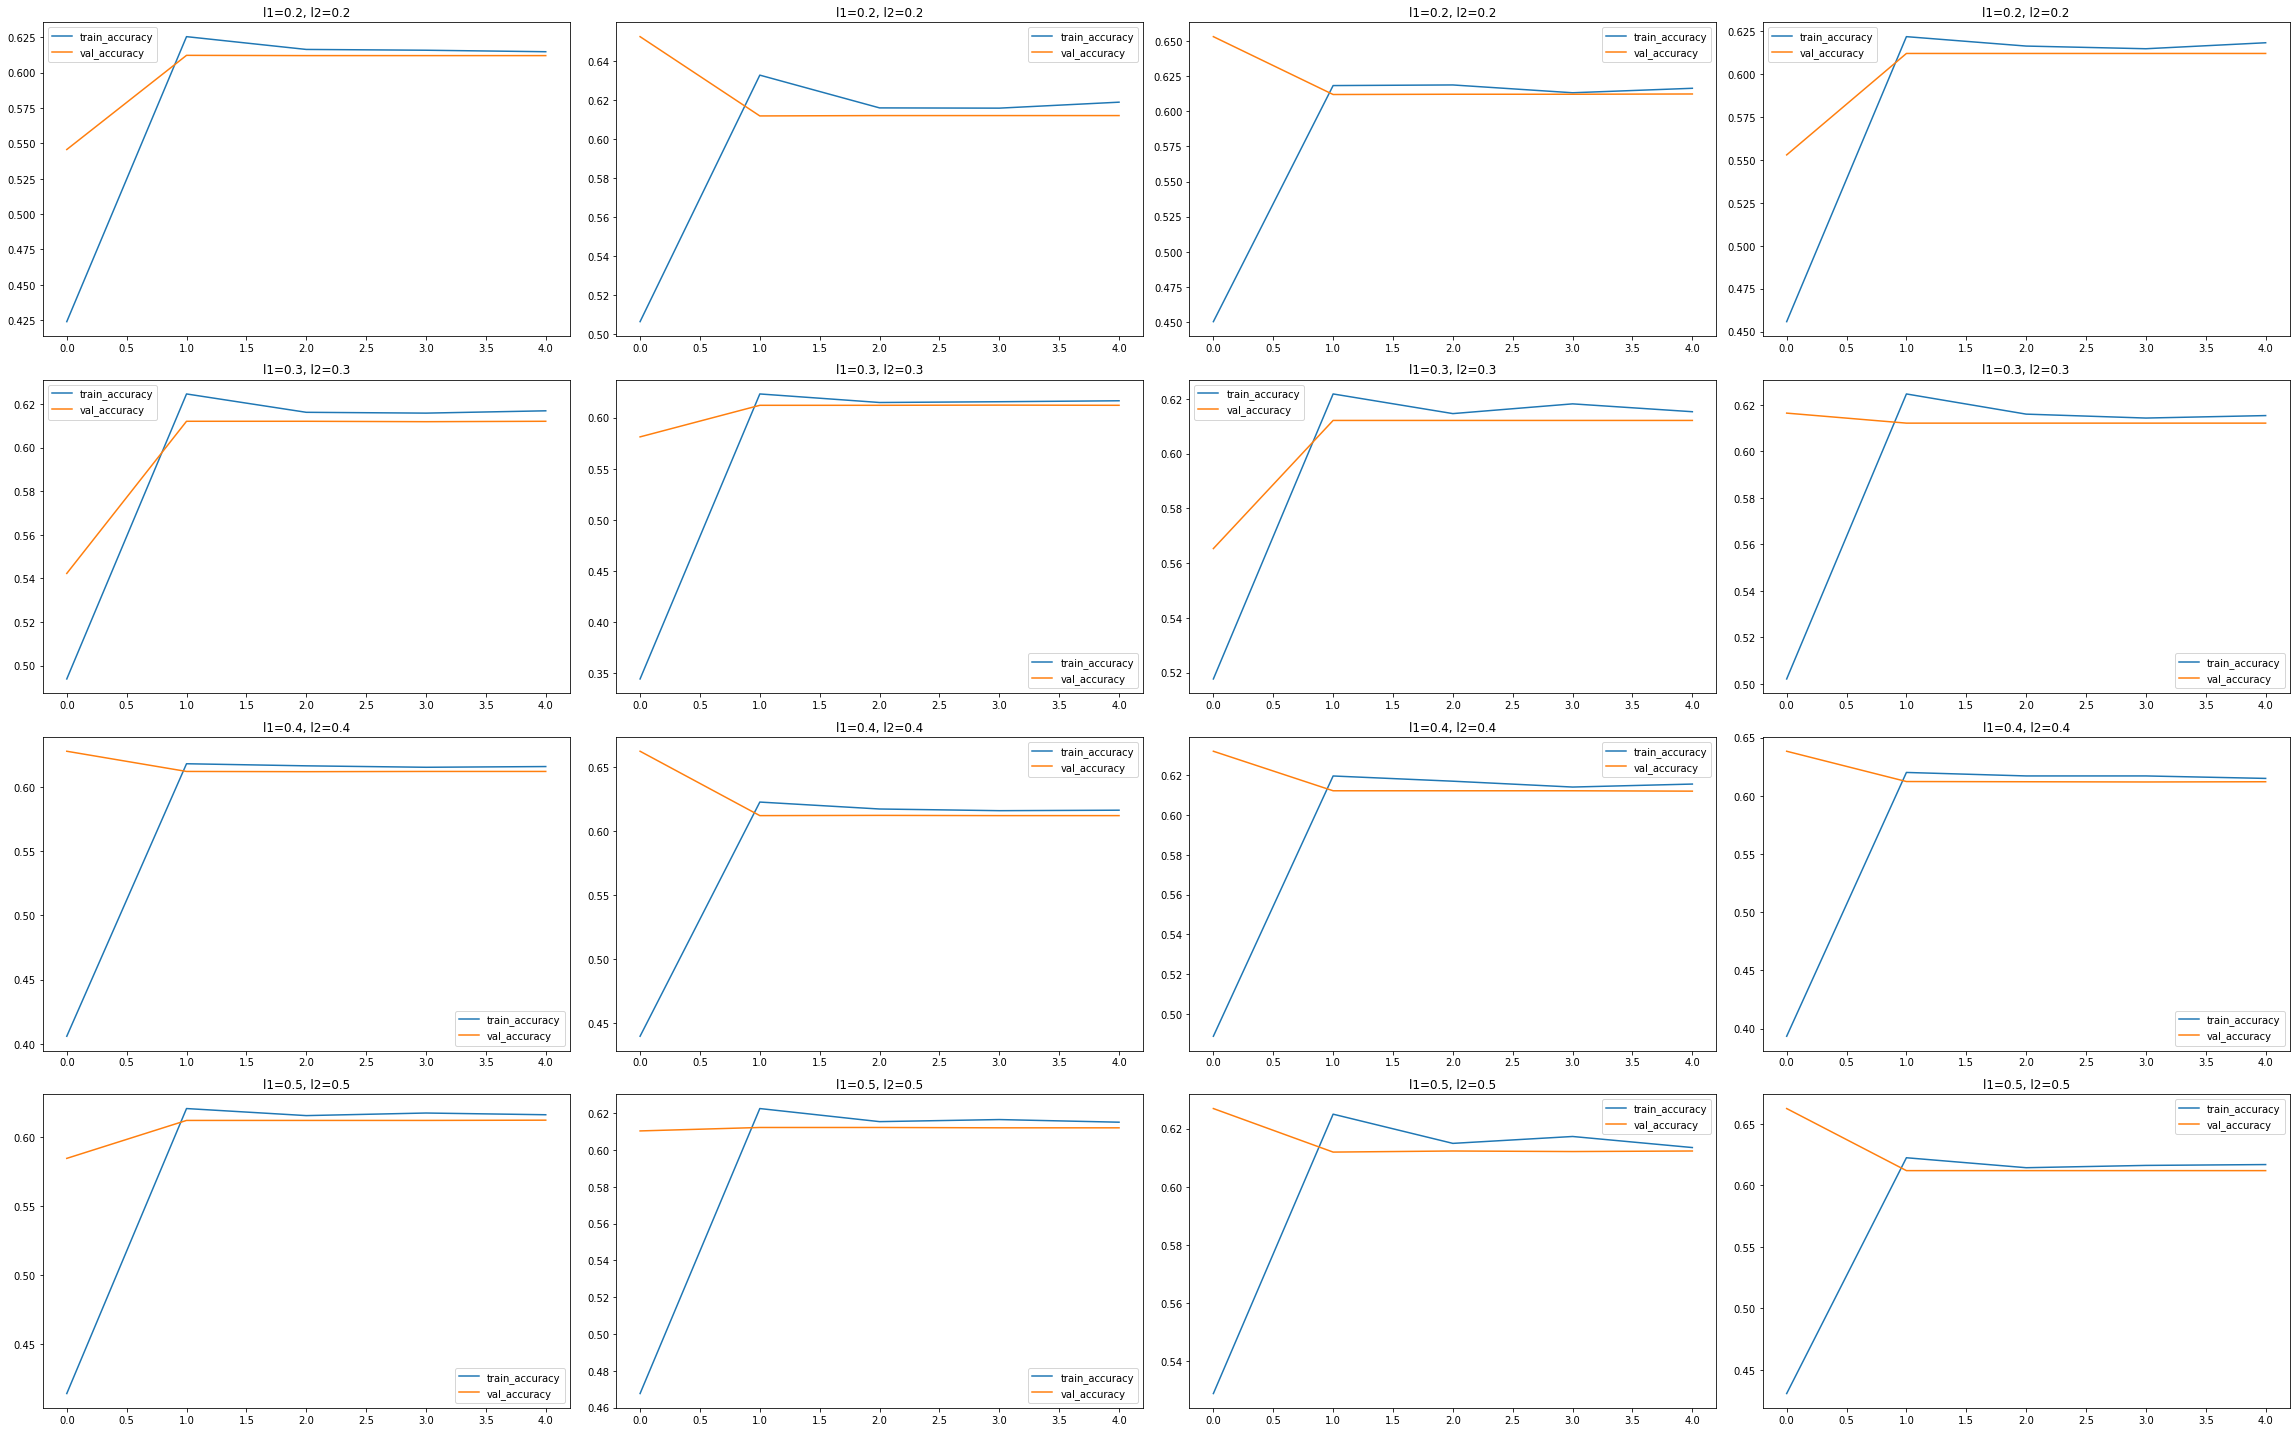

In [ ]:
fig, axes = plt.subplots(4, 4, figsize = (32, 20))

res_dp1_dp2 = []
for i in range(4):
  for j in range(4):
    keras.backend.clear_session()
    res_dp1_dp2.append(plot_training_resnet_lr(df_train, df_valid, dp1[i], dp2[i], axes[i][j]))
fig.tight_layout() 

# Combine Models

In [36]:
# https://stackoverflow.com/questions/54151671/graph-disconnected-cannot-obtain-value-for-tensor-tensor
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.layers import concatenate
inputshape = (300, 300, 3)
inputs = tf.keras.Input(shape=inputshape)
x = data_augmentation(inputs)

resnet50_model = tf.keras.applications.ResNet50(include_top = False, input_shape = inputshape, weights="imagenet")
x = resnet50_model(x)
# x.trainable = False

model = tf.keras.layers.GlobalMaxPooling2D()(x) 

# model = BatchNormalization()(model) 
model = Dense(512, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.001, l2 = 0.001))(model)

# model = Dropout(0.3)(model)
model = BatchNormalization()(model)
model = Dense(256, activation = "relu",kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)

# # model = BatchNormalization()(model)
model = Dense(32,activation='relu',kernel_initializer='he_normal',kernel_regularizer=tf.keras.regularizers.L1L2(l1 = 0.01, l2 = 0.01))(model)

# model = Dropout(0.4)(model)
out = Dense(5, activation = "softmax")(model)

model_1 = Model(inputs = inputs, outputs = out)


x = data_augmentation(inputs)
vgg16_model = VGG16(include_top = False, input_shape = inputshape, weights="imagenet")
x = vgg16_model(x)
# x.trainable = False

# model = tf.keras.layers.GlobalAveragePooling2D()(x) 
model = Dense(256, activation = "relu",kernel_initializer='he_normal')(model)
# model = Dropout(0.4)(model)
model = Dense(128,activation='relu',kernel_initializer='he_normal')(model)
# model = Dropout(0.4)(model)
out = Dense(5, activation = "softmax")(model)

model_2 = Model(inputs = inputs, outputs = out)
merged = concatenate([model_1.output, model_2.output])

# merged=Flatten()(merged)
merged = Dense(5, activation='softmax')(merged)
model_fusion = Model(inputs, merged)

In [37]:
opt = keras.optimizers.Adam(1e-5)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=4, min_lr = 1e-5, cooldown=2)

es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights = True)
model_fusion.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
print(Batch_Size) 

16


In [38]:
steps_per_epoch = num_training // Batch_Size
valid_steps = num_valid // Batch_Size
history = model_fusion.fit(df_train, validation_data=df_valid, validation_steps=valid_steps, epochs=50, steps_per_epoch=steps_per_epoch, callbacks = [es, rlrop])

Epoch 1/50
1002/1002 [==============================] - 202s 193ms/step - loss: 103.8679 - accuracy: 0.3502 - val_loss: 90.2577 - val_accuracy: 0.6068
Epoch 2/50
1002/1002 [==============================] - 192s 191ms/step - loss: 85.9351 - accuracy: 0.6261 - val_loss: 73.6831 - val_accuracy: 0.6424
Epoch 3/50
1002/1002 [==============================] - 191s 191ms/step - loss: 69.9384 - accuracy: 0.6574 - val_loss: 59.2678 - val_accuracy: 0.6828
Epoch 4/50
1002/1002 [==============================] - 191s 191ms/step - loss: 56.0381 - accuracy: 0.6897 - val_loss: 46.8888 - val_accuracy: 0.7274
Epoch 5/50
1002/1002 [==============================] - 191s 191ms/step - loss: 44.1510 - accuracy: 0.7316 - val_loss: 36.4375 - val_accuracy: 0.7567
Epoch 6/50
1002/1002 [==============================] - 192s 191ms/step - loss: 34.1626 - accuracy: 0.7468 - val_loss: 27.7674 - val_accuracy: 0.7556
Epoch 7/50
1002/1002 [==============================] - 192s 191ms/step - loss: 25.8911 - accuracy:

KeyboardInterrupt: ignored

In [220]:
# save model
from keras.models import load_model
import os
def save_model(model, name):
  model_name = '{}.h5'.format(name)
  save_dir = os.path.join(os.getcwd(), 'saved_models')
  
  # Save model and weights
  if not os.path.isdir(save_dir):
      os.makedirs(save_dir)
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at %s ' % model_path)


save_model(model_fusion, 'model_fusion2')

Saved trained model at /content/saved_models/model_fusion.h5 


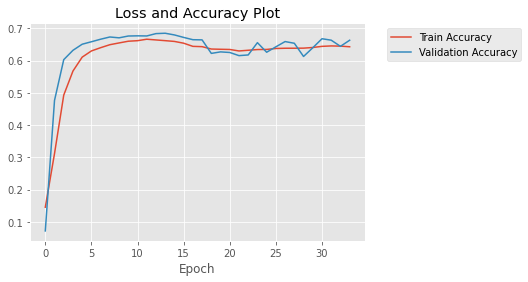

In [221]:
N = 34
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["accuracy"], label="Train Accuracy")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="Validation Accuracy")

plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

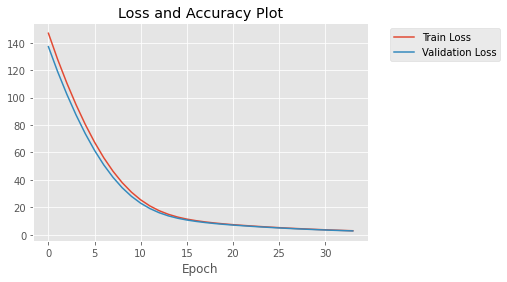

In [222]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="Train Loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="Validation Loss")
plt.title("Loss and Accuracy Plot")
plt.xlabel("Epoch")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

In [195]:
model_fusion.summary()

Model: "model_57"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 300, 300, 3)  0           input_153[0][0]                  
                                                                 input_153[0][0]                  
__________________________________________________________________________________________________
resnet50 (Functional)           (None, 10, 10, 2048) 23587712    sequential_1[17][0]              
__________________________________________________________________________________________________
global_max_pooling2d_21 (Global (None, 2048)         0           resnet50[0][0]            